# Entrega 2

## Librerias

In [1]:
# Librerias
#!pip install rasterio
#!pip install seaborn
#!pip install scikit-image

In [1]:
from sklearn.preprocessing import MinMaxScaler
from typing import List
from matplotlib import colors
from skimage import exposure

import rasterio as rio
import rasterio.plot as rio_plot
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import json

# Semilla pseudoaleatoria
np.random.seed(24)

# Tamaño de las figuras
plt.rcParams["figure.figsize"] = (20,10)

# Ruta base de la carpeta de datos
DATA_BASE = "/home/ggonzr_cloud/deeplearn/data"

## Exploración

En este apartado vamos a explorar algunas imagenes del conjunto de datos, los archivos que contiene la etiqueta de la imagen y la máscara.

### Carga de imágenes

A continuación vamos a buscar las rutas de acceso a las imagenes. Dado a que el conjunto de etiquetas es más pequeño que las imagenes, vamos a emplear un conjunto reducido tal que tengamos etiquetas para todas la imagenes a emplear

In [2]:
# Directorios de las etiquetas y la imagenes
LABEL_DIR = f"{DATA_BASE}/ref_landcovernet_v1_labels"
IMAGE_DIR = f"{DATA_BASE}/ref_landcovernet_v1_source"

In [3]:
# Listar los subdirectorios de cada carpeta: Etiquetas
label_dirs = glob.glob(f"{LABEL_DIR}/*")
print(f"Número de etiquetas disponibles: {len(label_dirs)}")

Número de etiquetas disponibles: 1982


In [4]:
# Listar los subdirectorios de cada carpeta: Etiquetas
image_dirs = glob.glob(f"{IMAGE_DIR}/*")
print(f"Número de etiquetas disponibles: {len(image_dirs)}")

Número de etiquetas disponibles: 82430


In [5]:
label_dirs[0]

'/home/ggonzr_cloud/deeplearn/data/ref_landcovernet_v1_labels/ref_landcovernet_v1_labels_36PZC_07'

In [6]:
image_dirs[0]

'/home/ggonzr_cloud/deeplearn/data/ref_landcovernet_v1_source/ref_landcovernet_v1_source_33LYE_11_20180818'

## Carga del preprocesamiento

Con base en el resumen que elaboramos anteriormente sobre las imagenes disponibles y su media de máscara de nubes, vamos a determinar cuántas imagenes tenemos disponibles con un porcentaje de nubes de 1%, 5% y 10%

In [7]:
mask_clouds_df = pd.read_json(f"{DATA_BASE}/cloud_mask_report.json")

In [8]:
print(f"Imagenes analizadas: {mask_clouds_df.count()[0]}")

Imagenes analizadas: 82398


In [9]:
# Datos
mask_clouds_df.head(2)

,image_id,chip_id,image_folder_path,cloud_mask_mean
0,33LYE_11_20180818,33LYE_11,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0
1,35LNF_07_20180602,35LNF_07,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0


In [10]:
# Datos con una media de nubes menor a 0.1%
percentage_1_mask_clouds = mask_clouds_df[mask_clouds_df.cloud_mask_mean <= 0.001]
percentage_1_mask_clouds.count()

image_id             32927
chip_id              32927
image_folder_path    32927
cloud_mask_mean      32927
dtype: int64

In [11]:
# Agrupar los datos por chip
cols = ["chip_id", "image_id"]
p1_group_count = (
    percentage_1_mask_clouds[cols]
    .groupby("chip_id")
    .count()
)

In [12]:
# Describir la consulta
p1_group_count.describe()

,image_id
count,1837.000000
mean,17.924333
std,12.681203
min,1.000000
25%,8.000000
50%,16.000000
75%,26.000000
max,76.000000


Como podemos observar, tenemos a nuestra disposición 1837 regiones diferentes que poseen imagenes con una probabilidad de cobertura de nubes menor a 1%. De estos grupos, en promedio cada uno posee 17 observaciones (tomas) de esa región. El 25% de este conjunto posee un número de observaciones temporales menor o igual a 8 tomas. Con ello en mente, vamos a seleccionar aquellos grupos que posean un número de imagenes de al menos 10 ejemplos.

In [13]:
GROUP_NUM_EXAMPLES = 10
p1_group_boundary = p1_group_count[p1_group_count.image_id >= GROUP_NUM_EXAMPLES]
print(f"Número de grupos: {p1_group_boundary.count()[0]}")

Número de grupos: 1279


Con ello en mente tendríamos 1279 grupos. Para culminar vamos a reajustar el conjunto de datos para leer las imagenes

In [14]:
# Realizar el join
p1_final_groups = (
    percentage_1_mask_clouds
    .join(
        p1_group_boundary,
        on="chip_id",
        how="inner",
        lsuffix="_p1_mask",
        rsuffix="_p1_group"
    )
)

# Limpiar
p1_final_groups = p1_final_groups.drop(columns=["image_id_p1_group"])
p1_final_groups = p1_final_groups.rename(columns={"image_id_p1_mask": "image_id"}, errors="raise")

In [15]:
p1_final_groups

,image_id,chip_id,image_folder_path,cloud_mask_mean
0,33LYE_11_20180818,33LYE_11,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
1798,33LYE_11_20180704,33LYE_11,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
2844,33LYE_11_20181121,33LYE_11,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
15990,33LYE_11_20180311,33LYE_11,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
22345,33LYE_11_20181211,33LYE_11,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
...,...,...,...,...
67613,29PKL_24_20181110,29PKL_24,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
68712,29PKL_24_20181011,29PKL_24,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
69956,29PKL_24_20181215,29PKL_24,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000
75430,29PKL_24_20181130,29PKL_24,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.000000


## Visualización

Ya con la vista lista, vamos a seleccionar de manera aleatoria una imagen para mostrar

In [16]:
img_sample = (
    p1_final_groups
    .sample(
        n=1,
        random_state=24
    )
)

In [26]:
img_sample

,image_id,chip_id,image_folder_path,cloud_mask_mean
32899,34JHS_03_20180125,34JHS_03,/home/ggonzr_cloud/deeplearn/data/ref_landcove...,0.0


In [31]:
img_sample_region = img_sample.iloc[0, 1]
print(f"Región seleccionada: {img_sample_region}")

Región seleccionada: 34JHS_03


Seguidamente vamos a seleccionar la máscara y una de las imágenes

In [29]:
mask_info = pd.read_json(f"{DATA_BASE}/image_view.json")

Directorio de la máscara

In [33]:
ex_mask_folder = mask_info.loc["masks", img_sample_region][0]
ex_mask = glob.glob(f"{ex_mask_folder}/labels.*")[0]

Directorio de la imagen

In [35]:
ex_img_folder = img_sample.iloc[0, 2]

Para el conjunto de datos de cobertura de terreno en África, cada una de las carpetas de las imagenes de terreno posee un archivo TIFF para cada banda respectiva. En esta ocasión vamos a seleccionar las bandas Rojo, Verde y Azul para realizar una composición en RGB.

In [37]:
# Bandas RGB de la imagen de ejemplo
ex_img_red = glob.glob(f"{ex_img_folder}/B04.*")[0]
ex_img_green = glob.glob(f"{ex_img_folder}/B03.*")[0]
ex_img_blue = glob.glob(f"{ex_img_folder}/B02.*")[0]

Con ello en mente tenemos las siguientes rutas

In [38]:
print(f"Banda roja de la imagen de ejemplo")
print(ex_img_red)

Banda roja de la imagen de ejemplo
/home/ggonzr_cloud/deeplearn/data/ref_landcovernet_v1_source/ref_landcovernet_v1_source_34JHS_03_20180125/B04.tif


In [39]:
print(f"Máscara semantica")
print(ex_mask)

Máscara semantica
/home/ggonzr_cloud/deeplearn/data/ref_landcovernet_v1_labels/ref_landcovernet_v1_labels_34JHS_03/labels.tif


### Cargar y visualizar

#### Máscara

In [40]:
ex_mask_rio = rio.open(ex_mask)

In [41]:
print(f"Metadatos{ex_mask_rio.meta}")

Metadatos{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 256, 'height': 256, 'count': 2, 'crs': CRS.from_epsg(32734), 'transform': Affine(10.0, 0.0, 896440.0,
       0.0, -10.0, 7094770.0)}


In [42]:
# Primera capa con las etiquetas
ex_labels_mask = ex_mask_rio.read(1)

In [43]:
ex_labels_mask

array([[6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6],
       ...,
       [6, 6, 6, ..., 6, 6, 6],
       [7, 6, 6, ..., 6, 6, 6],
       [6, 6, 6, ..., 6, 6, 6]], dtype=uint16)

In [44]:
# Crear un colormap personalizado para cada una de las etiquetas
# según el documento
cmap = colors.ListedColormap([
    "#0000ff",
    "#888888",
    "#d1a46d",
    "#f5f5ff",
    "#d64c2b",
    "#186818",
    "#00ff00"
])
meaning = [
    "Agua",
    "Suelo desnudo artificial",
    "Suelo desnudo natural",
    "Nieve",
    "Bosque (Woody soil)",
    "Terreno cultivado",
    "Vegetación (semi) natural"
]
boundaries = list(range(1,8))
norm = colors.BoundaryNorm(boundaries, cmap.N)

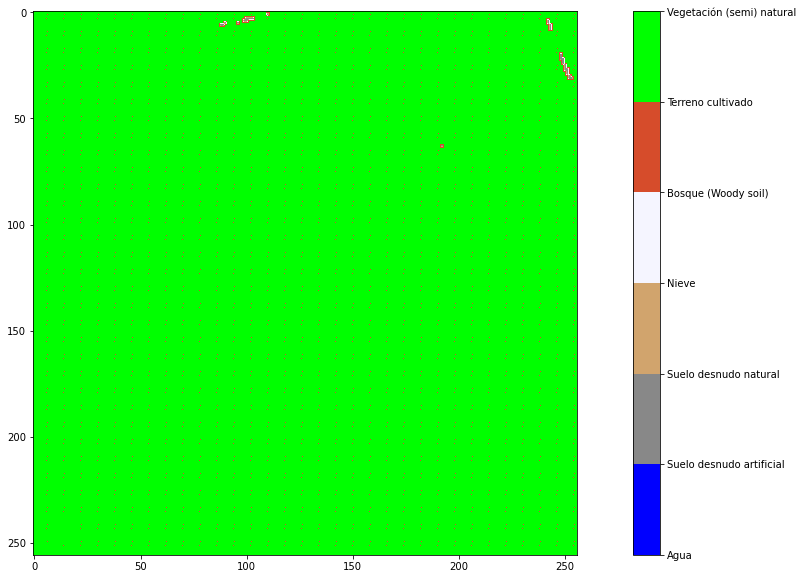

In [45]:
fig, ax = plt.subplots()
img = ax.imshow(ex_mask_rio.read(1), cmap=cmap, norm=norm)
cbar = plt.colorbar(img, ax=ax)
cbar.set_ticks(boundaries)
cbar.set_ticklabels(meaning)
cbar.config_axis
plt.show()

#### Imagen

In [46]:
ex_image_red_rio = rio.open(ex_img_red)
ex_image_green_rio = rio.open(ex_img_green)
ex_image_blue_rio = rio.open(ex_img_blue)

In [47]:
print(f"Metadatos{ex_image_red_rio.meta}")

Metadatos{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 256, 'height': 256, 'count': 1, 'crs': CRS.from_epsg(32734), 'transform': Affine(10.0, 0.0, 896440.0,
       0.0, -10.0, 7094770.0)}


Como podemos observar, la imagen posee 10 bandas. A continuación, vamos a visualizar la imagen en combinación de color verdadero

In [48]:
ex_image_red_rio_data = ex_image_red_rio.read(1)
ex_image_green_rio_data = ex_image_green_rio.read(1)
ex_image_green_rio_data = ex_image_blue_rio.read(1)

Escalar la imagen

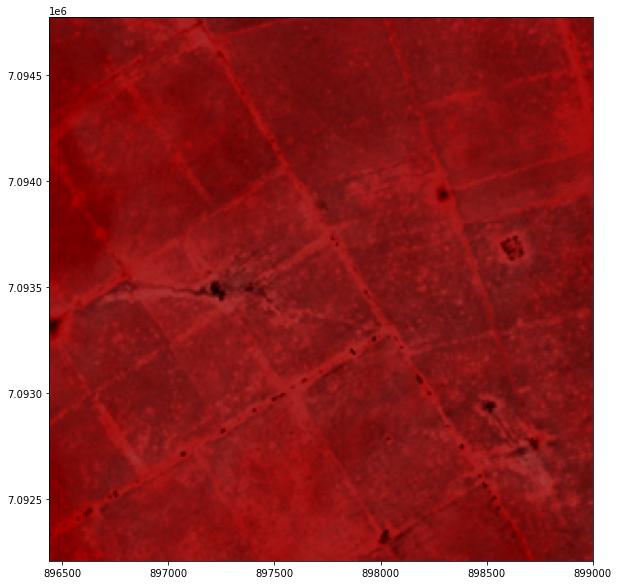

<AxesSubplot:>

In [49]:
# Combinación RGB
ex_image_rgb = np.array([
    ex_image_red_rio_data,
    ex_image_green_rio_data,
    ex_image_green_rio_data
])

# Reescalar los datos de las bandas
mms = MinMaxScaler(feature_range=(0, 255))
ex_c = ex_image_rgb.copy()
p2, p98 = np.percentile(ex_c, (2,98))

image = exposure.rescale_intensity(ex_c, in_range=(p2, p98)) / 100000

#for band in range(ex_c.shape[0]):
#    ex_c[band] = mms.fit_transform(ex_c[band])

# Mostrar
rio_plot.show(image, transform=ex_image_red_rio.transform)

#### Clasificacion de escena

In [50]:
ex_mask = glob.glob(f"{ex_img_folder}/SCL.*")[0]
ex_mask_rio = rio.open(ex_mask)

In [51]:
print(f"Metadatos{ex_mask_rio.meta}")

Metadatos{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 256, 'height': 256, 'count': 1, 'crs': CRS.from_epsg(32734), 'transform': Affine(10.0, 0.0, 896440.0,
       0.0, -10.0, 7094770.0)}


In [52]:
# Primera capa con las etiquetas
ex_labels_mask = ex_mask_rio.read(1)

In [53]:
ex_labels_mask

array([[5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       ...,
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5],
       [5, 5, 5, ..., 5, 5, 5]], dtype=uint8)

In [54]:
# Crear un colormap personalizado para cada una de las etiquetas
# según el documento
cmap = colors.ListedColormap([
    "#0000ff",
    "#888888",
    "#d1a46d",
    "#f5f5ff",
    "#d64c2b",
    "#186818",
    "#00ff00"
])
meaning = [
    "Agua",
    "Suelo desnudo artificial",
    "Suelo desnudo natural",
    "Nieve",
    "Bosque (Woody soil)",
    "Terreno cultivado",
    "Vegetación (semi) natural"
]
boundaries = list(range(1,8))
norm = colors.BoundaryNorm(boundaries, cmap.N)

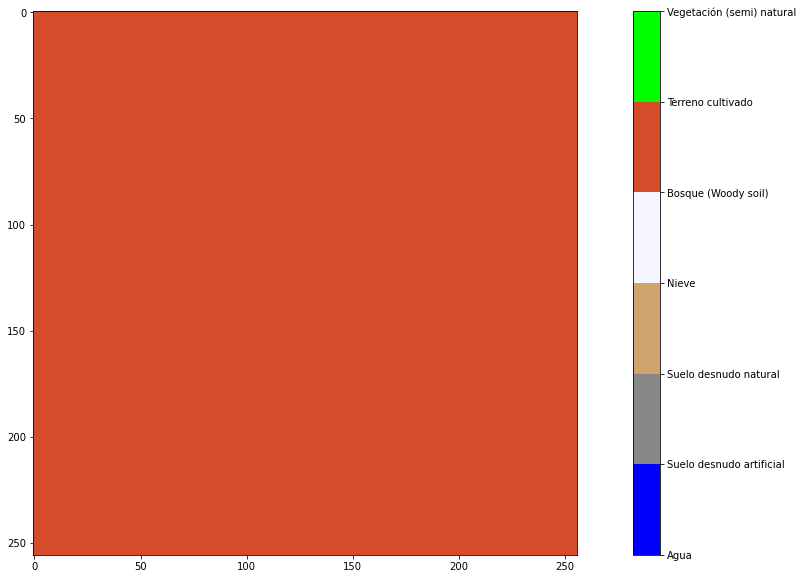

In [55]:
fig, ax = plt.subplots()
img = ax.imshow(ex_mask_rio.read(1), cmap=cmap, norm=norm)
cbar = plt.colorbar(img, ax=ax)
cbar.set_ticks(boundaries)
cbar.set_ticklabels(meaning)
cbar.config_axis
plt.show()

#### Mapa de nubes

In [56]:
ex_img_cloudmask = glob.glob(f"{ex_img_folder}/CLD.*")[0]
ex_cloud_mask = rio.open(ex_img_cloudmask)

In [57]:
print(f"Metadatos de la máscara de nubes: {ex_cloud_mask.meta}")

Metadatos de la máscara de nubes: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 256, 'height': 256, 'count': 1, 'crs': CRS.from_epsg(32734), 'transform': Affine(10.0, 0.0, 896440.0,
       0.0, -10.0, 7094770.0)}


In [58]:
cloud_layer = ex_cloud_mask.read(1)

In [59]:
np.mean(cloud_layer)

0.0

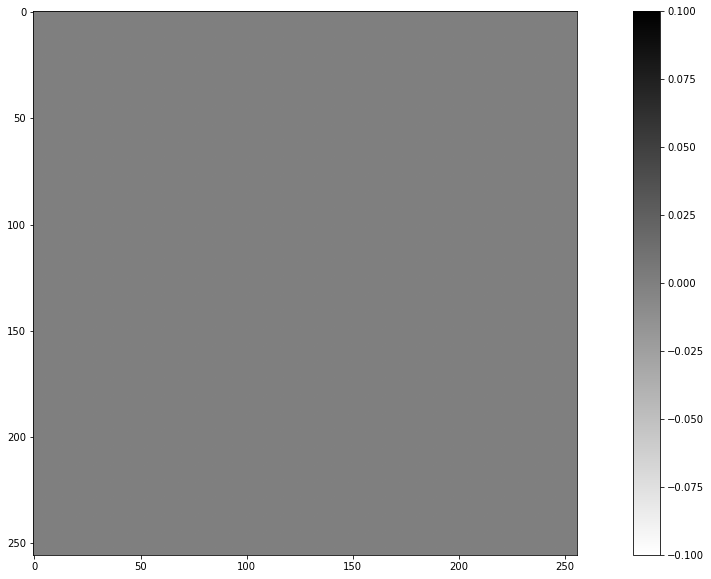

In [60]:
fig, ax = plt.subplots()
img = ax.imshow(ex_cloud_mask.read(1), cmap=plt.get_cmap("gist_yarg"))
fig.colorbar(img, ax=ax)